# Cross Train Test

cross train test using trisplit models (seq+energy)

In [40]:
import os
import pandas as pd

In [27]:
os.chdir('/scratch/cl1205/protease-gcnn-pytorch/model')
from utils import *
from models import *
from sklearn.metrics import roc_curve, auc, average_precision_score

In [62]:
def test(X, graph, y, testmask, model_for_test, hidden1, linear, learning_rate, weight_decay, batch_size, dropout, path_save,new=False):
    checkpoint = torch.load(path_save)
    model_for_test.load_state_dict(checkpoint['state_dict'])
    print('model loaded')
    if new == False:
        #if testmask != None:
        print('testmask is not none. good.')
        X = X[testmask]
        graph = graph[testmask]
        y = y[testmask]
        #else:
        #    print('testmask is none. bad!')
        with torch.no_grad():
            model_for_test.eval()
            #for j in range(100):
            logits_test = model_for_test(X, graph)
            test_acc = accuracy(logits_test, torch.argmax(y,axis=1))
                #if test_acc > max_acc:
                 #   logits_test_fin = logits_test
                  #  max_acc = test_acc
        return logits_test, test_acc
    else:
        with torch.no_grad():
            model_for_test.eval()
            logits_test = model_for_test(X, graph)
            return logits_test
def getAUC(true, proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # cleaved = 0
    fpr, tpr, _ = roc_curve(true, proba[:,0], pos_label=0)
    roc_auc = auc(fpr, tpr) #only for binary class
    return '{:.4f}'.format(roc_auc)
def precision_recall(true, predict, pos_label=0):
    # true positive, false negative, false positive
    tp = np.sum(true[np.where(predict == pos_label)] == pos_label)
    fp = np.sum(true[np.where(predict == pos_label)] != pos_label)
    fn = np.sum(true[np.where(predict != pos_label)] == pos_label)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    ap = average_precision_score(true, predict)
    return precision, recall, f1, ap
def getMetrics(path, dataList, split=2): # modified based on getCrossTestMetrics
    results = []
    # logits_test_HCV_WT_binary_10_ang_aa_energy_7_energyedge_5_hbond_model_model_for_test_A171T_seq_energy
    results.append(['data', 'feature','accuracy', 'auc', 'precision', 'recall', 'f1', 'ap'])
    for data in dataList:
        y = pkl.load(open('/scratch/cl1205/protease-gcnn-pytorch/data/ind.' + data[0] + '_binary_10_ang_aa_energy_7_energyedge_5_hbond.y', 'rb'))
        if split == 2:
            maskPath = '/scratch/cl1205/protease-gcnn-pytorch/data/ind.' + data[0] + '_binary_10_ang_aa_energy_7_energyedge_5_hbond.test.index'
        elif split == 3:
            maskPath = '/scratch/cl1205/protease-gcnn-pytorch/data/ind.' + data[0] + '_binary_10_ang_aa_energy_7_energyedge_5_hbond.trisplit.test.index'

        mask = np.loadtxt(maskPath, dtype=int)
        mask = np.sort(mask)
        #adj_ls, features, labels, sequences, proteases, labelorder, train_mask, test_mask = load_data(data + '_binary_10_ang_aa_energy_7_energyedge_5_hbond', is_test=data + '_binary_10_ang_aa_energy_7_energyedge_5_hbond', norm_type=False, test_format = 'split', energy_only=False, noenergy=False)
        if data == 'WT' or data == 'all': #Just for HCV
            y = y[mask[:-1],:]
        else:
            y = y[mask,:]
#         y = y[mask, :]
        print(data)
#         y = labels[test_mask]
        logits_test = pkl.load(open(data[1], 'rb'))
        feature = data[1].split('/')[-2]
        acc = getAcc(logits_test, np.argmax(y,axis=1))
        precision, recall, f1, ap = precision_recall(np.argmax(y,axis=1), np.argmax(logits_test.cpu().detach().numpy(),axis=1))
        #proba = softmax(logits_test.numpy(),1)
        proba = nn.functional.softmax(logits_test)
        auc = float(getAUC(np.argmax(y,axis=1), proba))
        results.append([data[0], feature, acc, auc, precision, recall, f1, ap])
    results = pd.DataFrame(results[1:], columns = results[0])
    return results


In [63]:
# implant from post_analysis.ipynb
def crossTest(dataset = 'HCV_WT_binary_10_ang_aa_energy_7_energyedge_5_hbond', 
                feature_type = 'energy', 
               modelPath = 'model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.001_bs_10_dt_0.05.pth',
             modelName = 'HCV_WT_binary_10_ang_energy_7_energyedge_5_hbond'):
    if feature_type == 'energy':
        is_energy_only = True
    else:
        is_energy_only = False
    adj_ls, features, labels, sequences, proteases, labelorder, train_mask, val_test, test_mask = load_data(dataset, is_test=dataset, is_val=dataset, norm_type=True, test_format = 'split', noenergy=False, energy_only=is_energy_only)
#     if feature_type == 'energy':
#         compPath = 'HCV_' + modelName + '_binary_10_ang_energy_7_energyedge_5_hbond'
#     elif feature_type == 'complete':
#         compPath = 'HCV_' + modelName + '_binary_10_ang_aa_energy_7_energyedge_5_hbond'
#     elif feature_type == 'seq':
#         compPath = 'HCV_' + modelName + '_binary_10_ang_aa_'

        
#     path = os.path.join('/scratch/cl1205/protease-gcnn-pytorch/model/outputs/tt_finalize_20220211/' + compPath +
#                         '/bs_' + modelPath.split('_')[-3], modelPath)
    path = os.path.join('/projects/f_sdk94_1/PGCN/HCV/trisplit/models/', 
                        os.path.join(modelName, feature_type + '/' + modelPath))
    print(path)
    name = modelPath
    bs = int(name.split('_')[-3])
    wd = float(name.split('_')[-5])
    lr = float(name.split('_')[-7])
    dt = float(name.split('_')[-1][0:-4])
    model = GCN(nnode=features.shape[1],
                nfeat=features.shape[2],
                mfeat=adj_ls.shape[3],
    #            ngcn=args.ngcn,
                hidden1=20,
                depth=2,
    #            hidden2=args.hidden2,
                natt=0, # one layer
                linear=0,
                weight='pre',
                is_des=False,
                nclass=2, #labels.shape[1],
                dropout=dt,
                cheby=None)
    logit_test, acc_test = test(X=features, graph=adj_ls, y=labels, testmask=test_mask, model_for_test=model, 
                                hidden1=20, linear=0, learning_rate=lr, weight_decay=wd, batch_size=bs, 
                                dropout=dt, 
                                path_save=path, 
                                new=False)
    y = labels[test_mask,:].numpy()
    precision, recall, f1, ap = precision_recall(np.argmax(y,axis=1), np.argmax(logit_test.cpu().detach().numpy(),axis=1))
    proba = nn.functional.softmax(logit_test)
    aucScore = float(getAUC(np.argmax(y,axis=1), proba))
    return acc_test, precision, recall, f1, ap, aucScore

In [ ]:
results_new = []
datas = ['WT','A171T','D183A','Triple', 'all']
for data in datas:
    for i, model in enumerate(modelPaths):
        acc, p, r, f1, ap, auc = crossTest(dataset = 'HCV_' + data + '_binary_10_ang_aa_energy_7_energyedge_5_hbond',
                                           modelPath = model, modelName = datas[i], is_energy_only=False)
        feature = 'Seq+Energy'
        results_new.append([data, datas[i], feature, acc.item(), p, r, f1, ap, auc])

In [ ]:
df = pd.DataFrame(results_new, columns = ['Data', 'Model', 'Feature', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP','AUC'])
df.head()

In [ ]:
value = 'AUC'
pd.pivot_table(df, values=[value], index=['Data', 'Feature'], columns=['Model']).reindex([(x, 'E-only') for x in datas])[[(value, x) for x in datas]]

## trisplit

### Seq+Energy

In [64]:
# median(accuracy)
modelPaths = ['model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.005_bs_50_dt_0.05.pth',
             'model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.3.pth',
             'model_for_test_seed_1_hidden_20_linear_0_lr_0.05_wd_0.0005_bs_500_dt_0.01.pth',
             'model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.001_bs_50_dt_0.05.pth',
             'model_for_test_seed_2_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.4.pth']
datas = ['WT','A171T','D183A','Triple', 'Combined']

In [66]:
from sklearn.metrics import roc_curve, auc, average_precision_score
results_new = []
for data in datas:
    if data == 'Combined':
        name = 'all'
    else:
        name = data
    for i, model in enumerate(modelPaths):
        print(datas[i])
        acc, p, r, f1, ap, aucScore = crossTest(dataset = 'HCV_' + name + '_binary_10_ang_aa_energy_7_energyedge_5_hbond',
                                           modelPath = model, modelName = datas[i], feature_type='complete')
        feature = 'Seq+Energy'
        results_new.append([data, datas[i], feature, acc.item(), p, r, f1, ap, aucScore])
df = pd.DataFrame(results_new, columns = ['Data', 'Model', 'Feature', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP','AUC'])
df.head()

WT
/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.005_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/complete/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.3.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.05_wd_0.0005_bs_500_dt_0.01.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.4.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.005_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/complete/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.3.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.05_wd_0.0005_bs_500_dt_0.01.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.4.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.005_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/complete/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.3.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.05_wd_0.0005_bs_500_dt_0.01.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.4.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.005_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/complete/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.3.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.05_wd_0.0005_bs_500_dt_0.01.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.4.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.005_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/complete/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.3.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/complete/model_for_test_seed_1_hidden_20_linear_0_lr_0.05_wd_0.0005_bs_500_dt_0.01.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/complete/model_for_test_seed_2_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_50_dt_0.4.pth
model loaded
testmask is not none. good.


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,Data,Model,Feature,Accuracy,Precision,Recall,F1,AP,AUC
0,WT,WT,Seq+Energy,0.921088,0.841026,0.858639,0.849741,0.938041,0.9539
1,WT,A171T,Seq+Energy,0.795918,0.566343,0.916230,0.700000,0.907682,0.8848
2,WT,D183A,Seq+Energy,0.857143,0.672000,0.879581,0.761905,0.920555,0.9049
3,WT,Triple,Seq+Energy,0.537415,0.358095,0.984293,0.525140,0.833582,0.8593
4,WT,Combined,Seq+Energy,0.931973,0.861538,0.879581,0.870466,0.946624,0.9691


In [67]:
df = pd.DataFrame(results_new, columns = ['Data', 'Model', 'Feature', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP','AUC'])
df.head()

,Data,Model,Feature,Accuracy,Precision,Recall,F1,AP,AUC
0,WT,WT,Seq+Energy,0.921088,0.841026,0.858639,0.849741,0.938041,0.9539
1,WT,A171T,Seq+Energy,0.795918,0.566343,0.916230,0.700000,0.907682,0.8848
2,WT,D183A,Seq+Energy,0.857143,0.672000,0.879581,0.761905,0.920555,0.9049
3,WT,Triple,Seq+Energy,0.537415,0.358095,0.984293,0.525140,0.833582,0.8593
4,WT,Combined,Seq+Energy,0.931973,0.861538,0.879581,0.870466,0.946624,0.9691


In [69]:
df.to_csv('CrossTestSummary_complete_trisplit.csv',index=None)

In [68]:
value = 'Accuracy'
pd.pivot_table(df, values=[value], index=['Data', 'Feature'], columns=['Model']).reindex([(x, 'Seq+Energy') for x in datas])[[(value, x) for x in datas]]

Accuracy                                        
Model                      WT     A171T     D183A    Triple  Combined
Data     Feature                                                     
WT       Seq+Energy  0.921088  0.795918  0.857143  0.537415  0.931973
A171T    Seq+Energy  0.864497  0.963664  0.320969  0.710825  0.960636
D183A    Seq+Energy  0.847515  0.841618  0.898905  0.835720  0.896377
Triple   Seq+Energy  0.820175  0.912281  0.691520  0.935673  0.934211
Combined Seq+Energy  0.862930  0.889682  0.660892  0.755924  0.922548

## Energy only

In [70]:
# median(accuracy)
modelPaths = ['model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.2.pth',
             'model_for_test_seed_2_hidden_20_linear_0_lr_0.01_wd_0.001_bs_1000_dt_0.2.pth',
             'model_for_test_seed_1_hidden_20_linear_0_lr_0.01_wd_0.001_bs_100_dt_0.2.pth',
             'model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.05.pth',
             'model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_10_dt_0.05.pth']
datas = ['WT','A171T','D183A','Triple', 'Combined']

In [71]:
results_new = []
for data in datas:
    if data == 'Combined':
        name = 'all'
    else:
        name = data
    for i, model in enumerate(modelPaths):
        print(datas[i])
        acc, p, r, f1, ap, aucScore = crossTest(dataset = 'HCV_' + name + '_binary_10_ang_aa_energy_7_energyedge_5_hbond',
                                           modelPath = model, modelName = datas[i], feature_type='energy')
        feature = 'E-only'
        results_new.append([data, datas[i], feature, acc.item(), p, r, f1, ap, aucScore])
df = pd.DataFrame(results_new, columns = ['Data', 'Model', 'Feature', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP','AUC'])
df.head()

WT
/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.2.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.01_wd_0.001_bs_1000_dt_0.2.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.01_wd_0.001_bs_100_dt_0.2.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/energy/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_10_dt_0.05.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.2.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.01_wd_0.001_bs_1000_dt_0.2.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.01_wd_0.001_bs_100_dt_0.2.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/energy/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_10_dt_0.05.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.2.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.01_wd_0.001_bs_1000_dt_0.2.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.01_wd_0.001_bs_100_dt_0.2.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/energy/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_10_dt_0.05.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.2.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.01_wd_0.001_bs_1000_dt_0.2.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.01_wd_0.001_bs_100_dt_0.2.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/energy/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_10_dt_0.05.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.2.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/energy/model_for_test_seed_2_hidden_20_linear_0_lr_0.01_wd_0.001_bs_1000_dt_0.2.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.01_wd_0.001_bs_100_dt_0.2.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/energy/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.05.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/energy/model_for_test_seed_3_hidden_20_linear_0_lr_0.0005_wd_0.0001_bs_10_dt_0.05.pth
model loaded
testmask is not none. good.


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,Data,Model,Feature,Accuracy,Precision,Recall,F1,AP,AUC
0,WT,WT,E-only,0.900680,0.817204,0.795812,0.806366,0.917160,0.9421
1,WT,A171T,E-only,0.808163,0.587413,0.879581,0.704403,0.903519,0.8918
2,WT,D183A,E-only,0.282993,0.266017,1.000000,0.420242,0.748257,0.6139
3,WT,Triple,E-only,0.265306,0.250358,0.916230,0.393258,0.733350,0.4709
4,WT,Combined,E-only,0.896599,0.804233,0.795812,0.800000,0.915755,0.9471


In [72]:
df.to_csv('CrossTestSummary_energy_trisplit.csv',index=None)

In [73]:
value = 'Accuracy'
pd.pivot_table(df, values=[value], index=['Data', 'Feature'], columns=['Model']).reindex([(x, 'E-only') for x in datas])[[(value, x) for x in datas]]

Accuracy                                        
Model                   WT     A171T     D183A    Triple  Combined
Data     Feature                                                  
WT       E-only   0.900680  0.808163  0.282993  0.265306  0.896599
A171T    E-only   0.827403  0.958365  0.282362  0.315670  0.956094
D183A    E-only   0.783488  0.827296  0.890480  0.793597  0.875316
Triple   E-only   0.782164  0.884503  0.577485  0.925439  0.923977
Combined E-only   0.816561  0.874395  0.513121  0.568917  0.910318

## Seq only

In [74]:
# median(accuracy)
modelPaths = ['model_for_test_seed_1_hidden_20_linear_0_lr_0.0005_wd_0.005_bs_50_dt_0.5.pth',
             'model_for_test_seed_1_hidden_20_linear_0_lr_0.001_wd_0.0005_bs_100_dt_0.4.pth',
             'model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.5.pth',
             'model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.5.pth',
             'model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.0001_bs_100_dt_0.1.pth']
datas = ['WT','A171T','D183A','Triple', 'Combined']

In [75]:
results_new = []
for data in datas:
    if data == 'Combined':
        name = 'all'
    else:
        name = data
    for i, model in enumerate(modelPaths):
        print(datas[i])
        acc, p, r, f1, ap, aucScore = crossTest(dataset = 'HCV_' + name + '_binary_10_ang_aa',
                                           modelPath = model, modelName = datas[i], feature_type='seq')
        feature = 'seq'
        results_new.append([data, datas[i], feature, acc.item(), p, r, f1, ap, aucScore])
df = pd.DataFrame(results_new, columns = ['Data', 'Model', 'Feature', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP','AUC'])
df.head()

WT
/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.0005_wd_0.005_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.001_wd_0.0005_bs_100_dt_0.4.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/seq/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.5.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/seq/model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.0001_bs_100_dt_0.1.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.0005_wd_0.005_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.001_wd_0.0005_bs_100_dt_0.4.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/seq/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.5.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/seq/model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.0001_bs_100_dt_0.1.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.0005_wd_0.005_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.001_wd_0.0005_bs_100_dt_0.4.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/seq/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.5.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/seq/model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.0001_bs_100_dt_0.1.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.0005_wd_0.005_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.001_wd_0.0005_bs_100_dt_0.4.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/seq/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.5.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/seq/model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.0001_bs_100_dt_0.1.pth
model loaded
testmask is not none. good.
WT


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/WT/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.0005_wd_0.005_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
A171T


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/A171T/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.001_wd_0.0005_bs_100_dt_0.4.pth
model loaded
testmask is not none. good.
D183A


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/D183A/seq/model_for_test_seed_2_hidden_20_linear_0_lr_0.005_wd_0.0005_bs_500_dt_0.5.pth
model loaded
testmask is not none. good.
Triple


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Triple/seq/model_for_test_seed_1_hidden_20_linear_0_lr_0.005_wd_0.0001_bs_50_dt_0.5.pth
model loaded
testmask is not none. good.
Combined


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/projects/f_sdk94_1/PGCN/HCV/trisplit/models/Combined/seq/model_for_test_seed_3_hidden_20_linear_0_lr_0.001_wd_0.0001_bs_100_dt_0.1.pth
model loaded
testmask is not none. good.


/projects/community/py-data-science-stack/5.1.0/kp807/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,Data,Model,Feature,Accuracy,Precision,Recall,F1,AP,AUC
0,WT,WT,seq,0.918367,0.842932,0.842932,0.842932,0.933563,0.9564
1,WT,A171T,seq,0.843537,0.640741,0.905759,0.750542,0.921857,0.9059
2,WT,D183A,seq,0.820408,0.598662,0.937173,0.730612,0.921225,0.9247
3,WT,Triple,seq,0.808163,0.581699,0.931937,0.716298,0.915683,0.8917
4,WT,Combined,seq,0.926531,0.844221,0.879581,0.861538,0.944726,0.9685


In [76]:
df.to_csv('CrossTestSummary_seq_trisplit.csv',index=None)

In [77]:
value = 'Accuracy'
pd.pivot_table(df, values=[value], index=['Data', 'Feature'], columns=['Model']).reindex([(x, 'seq') for x in datas])[[(value, x) for x in datas]]

Accuracy                                        
Model                   WT     A171T     D183A    Triple  Combined
Data     Feature                                                  
WT       seq      0.918367  0.843537  0.820408  0.808163  0.926531
A171T    seq      0.880394  0.965178  0.874338  0.946253  0.958365
D183A    seq      0.806234  0.861837  0.898905  0.862679  0.890480
Triple   seq      0.738304  0.915205  0.890351  0.937135  0.938596
Combined seq      0.843822  0.895541  0.875414  0.890446  0.923567

# overlap between data

In [1]:
import pandas as pd
import numpy as np

In [15]:
wt = pd.read_csv('HCV.txt', delimiter='\t')
a171t = pd.read_csv('HCV_A171T.txt', delimiter='\t')
d183a = pd.read_csv('HCV_D183A.txt', delimiter='\t')
triple = pd.read_csv('HCV_R170K_A171T_D183A.txt', delimiter='\t')
total = [wt['Sequence'].values.tolist(), a171t['Sequence'].values.tolist(), 
        d183a['Sequence'].values.tolist(), triple['Sequence'].values.tolist()]

In [25]:
overlaps = []
for i, data1 in enumerate(total):
    overlaps.append([])
    for data2 in total:
        overlaps[i].append(len(set(data1) & set(data2)) / len(set(data1)))
df = pd.DataFrame(overlaps, columns=['WT','A171T','D183A','Triple'], index=['WT','A171T','D183A','Triple'])
df

,WT,A171T,D183A,Triple
WT,1.000000,0.207629,0.163215,0.106540
A171T,0.115385,1.000000,0.269988,0.199425
D183A,0.100978,0.300573,1.000000,0.175742
Triple,0.114361,0.385200,0.304914,1.000000


<AxesSubplot:>

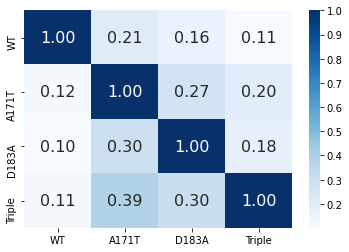

In [34]:
import seaborn as sns
sns.heatmap(df, annot=True, cmap='Blues', annot_kws={"fontsize":16}, fmt='.2f')

In [35]:
crossTest = pd.read_csv('~/Downloads/CrossTestSummary_complete_trisplit.csv')

In [41]:
pivot = pd.pivot_table(crossTest, values='Accuracy', aggfunc='mean', index='Model', columns='Data')
pivot = pivot.loc[['WT','A171T','D183A','Triple'], ['WT','A171T','D183A','Triple']]

<AxesSubplot:xlabel='Data', ylabel='Model'>

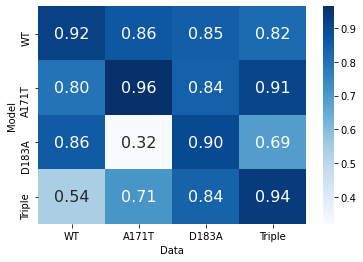

In [42]:
sns.heatmap(pivot, annot=True, cmap='Blues', annot_kws={"fontsize":16}, fmt='.2f')